In [1]:
import numpy as np
import matplotlib.pyplot as plt
from elf.io import open_file
import z5py
from pathlib import Path

import os
import imageio
import mobie
import mobie.metadata as metadata

from cryofib.n5_utils import read_volume, tif2n5

# Set paths

In [2]:
scratch_dir = Path("/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem")
fluo_dir = scratch_dir / "fluo"
em_dir = scratch_dir / "em"
segm_em_nuclei_dir = scratch_dir / "segm_em_nuclei"

In [3]:
with open_file(str(fluo_dir)) as f:
    ims = f["*.tiff"]
    print(ims.shape)

(55, 3343, 1482)


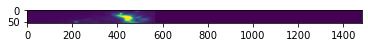

In [4]:
plt.imshow(ims[:, 100, :])

## Convert fluorescence tifs to n5

In [10]:
# tif2n5(tif_dir=fluo_dir,
#         n5_path=fluo_dir / "fluo.n5",
#         n5_key="raw",
#         reg_exp="*.tiff",
#         description="Raw fluorescence data",
#         order="zyx",
#         unit="nm",
#         resolution=(1849.5, 221.4, 221.4),
#         roi=None)

Reading tif files from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo
Read (55, 3343, 1482) of type uint8
Writing to /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5, key raw
Assigning attributes of the dataset


## Set information about mobie project

In [5]:
# the location of the mobie project that will be created
# we recommend that the mobie project folders have the structure <PROECJT_ROOT_FOLDER/data>
# the folder 'data' will contain the sub-folders for individual datasets
mobie_project_folder = "/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data"

## Create separate datasets

In [ ]:
# name of the dataset that will be created.
# one project can contain multiple datasets
dataset_name = "fluo-ds"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)

# the platform and number of jobs used for computation.
# choose 'local' to run computations on your machine.
# for large data, it is also possible to run computation on a cluster;
# for this purpose 'slurm' (for slurm cluster) and 'lsf' (for lsf cluster) are currently supported
target = "local"
max_jobs = 4

In [8]:
# The 'default' image for our example dataset is a 2d EM slice showing an overview of the dataset.
input_file = str(fluo_dir / "fluo.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "fluo"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "fluo"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]


In [12]:
unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[1, 2, 2]]

mobie.add_image(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    image_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_fluo-ds_fluo, max_jobs=4, config_dir=tmp_fluo-ds_fluo/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5, input_key=raw, scale_factors=[[1, 2, 2], [1, 2, 2], [1, 2, 2], [1, 2, 2]], halos=[[1, 2, 2], [1, 2, 2], [1, 2, 2], [1, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [1849.5, 221.4, 221.4], "unit": "nm", "setup_name": "fluo"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/fluo-ds/images/bdv-n5/fluo.n5, output_key_prefix=, force_copy=False, skip_existing_levels=False, scale_offset=0) is 

In [11]:
dataset_name = "raw-em-ds"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)
target = "local"
max_jobs = 4

input_file = str(em_dir / "em.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "em_raw"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "em_raw"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]

unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[2, 2, 2]]

mobie.add_image(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    image_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_raw-em-ds_em_raw, max_jobs=4, config_dir=tmp_raw-em-ds_em_raw/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5, input_key=raw, scale_factors=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], halos=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [30, 40, 30], "unit": "nm", "setup_name": "em_raw"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/raw-em-ds/images/bdv-n5/em_raw.n5, output_key_prefix=, force_copy=False, skip_existing_levels=False, scale_offset=0) is 

In [15]:
ds.attrs["resolution"]

[30, 40, 30]

In [16]:
dataset_name = "em-segm-nuclei-ds"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)
target = "local"
max_jobs = 4

input_file = str(segm_em_nuclei_dir / "em_nuclei.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "em_segm_nuclei"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "em_segm_nuclei"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]

unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[2, 2, 2]]

mobie.add_image(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    image_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_em-segm-nuclei-ds_em_segm_nuclei, max_jobs=4, config_dir=tmp_em-segm-nuclei-ds_em_segm_nuclei/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/segm_em_nuclei/em_nuclei.n5, input_key=raw, scale_factors=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], halos=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [30, 40, 30], "unit": "nm", "setup_name": "em_segm_nuclei"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/em-segm-nuclei-ds/images/bdv-n5/em_segm_nuclei.n5, output_key

# Put both EM and fluorescence together in one volume

In [23]:
dataset_name = "registration"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)
target = "local"
max_jobs = 4

input_file = str(fluo_dir / "fluo.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "fluo_raw"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "fluo_raw"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]

unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[2, 2, 2]]

mobie.add_image(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    image_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_registration_fluo_raw, max_jobs=4, config_dir=tmp_registration_fluo_raw/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5, input_key=raw, scale_factors=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], halos=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [1849.5, 221.4, 221.4], "unit": "nm", "setup_name": "fluo_raw"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/registration/images/bdv-n5/fluo_raw.n5, output_key_prefix=, force_copy=False, skip_existing_le

In [26]:
ds.shape

(55, 3343, 1482)

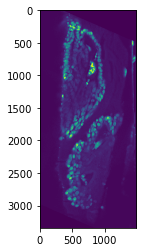

In [27]:
plt.imshow(ds[10, :, :])

In [18]:
dataset_name = "registration"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)
target = "local"
max_jobs = 4

input_file = str(em_dir / "em.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "em_raw"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "em_raw"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]

unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[2, 2, 2]]

mobie.add_image(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    image_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_registration_em_raw, max_jobs=4, config_dir=tmp_registration_em_raw/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5, input_key=raw, scale_factors=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], halos=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [30, 40, 30], "unit": "nm", "setup_name": "em_raw"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/registration/images/bdv-n5/em_raw.n5, output_key_prefix=, force_copy=False, skip_existing_levels=False, scale_offs

In [21]:
dataset_name = "registration"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)
target = "local"
max_jobs = 4

input_file = str(segm_em_nuclei_dir / "em_nuclei.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "em_segm_nuclei"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "em_segm_nuclei"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]

unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[2, 2, 2]]

mobie.add_segmentation(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    segmentation_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_registration_em_segm_nuclei, max_jobs=4, config_dir=tmp_registration_em_segm_nuclei/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/segm_em_nuclei/em_nuclei.n5, input_key=raw, scale_factors=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], halos=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [30, 40, 30], "unit": "nm", "setup_name": "em_segm_nuclei"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/registration/images/bdv-n5/em_segm_nuclei.n5, output_key_prefix=, force

In [13]:
dataset_name = "registration"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)
target = "local"
max_jobs = 4

input_file = str(em_dir / "em.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "em_registered1"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "em_registered1"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]

unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[2, 2, 2]]

affine_transform = [ 9.99010743e-01, -9.68391535e-03,  4.34022672e-02, -1.53353979e+04,
 -4.44694841e-02, -2.17549982e-01,  9.75035625e-01,  1.21702925e+05,
 -0.00000000e+00, -9.76001141e-01, -2.17765408e-01,  1.37783569e+05]

mobie.add_image(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    image_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit,
    transformation=affine_transform
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_registration_em_registered1, max_jobs=4, config_dir=tmp_registration_em_registered1/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5, input_key=raw, scale_factors=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], halos=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [30, 40, 30], "unit": "nm", "setup_name": "em_registered1"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/registration/images/bdv-n5/em_registered1.n5, output_key_prefix=, force_copy=False, skip_e

In [14]:
dataset_name = "registration"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)
target = "local"
max_jobs = 4

input_file = str(em_dir / "em.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "em_registered2"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "em_registered2"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]

unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[2, 2, 2]]

affine_transform = [ 9.99010743e-01, -4.44694841e-02,  1.47001615e-18,  2.07322935e+04,
 -9.68391535e-03, -2.17549982e-01, -9.76001141e-01,  1.60804883e+05,
 4.34022672e-02,  9.75035625e-01, -2.17765408e-01, -8.79946014e+04]

mobie.add_image(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    image_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit,
    transformation=affine_transform
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_registration_em_registered2, max_jobs=4, config_dir=tmp_registration_em_registered2/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5, input_key=raw, scale_factors=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], halos=[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [30, 40, 30], "unit": "nm", "setup_name": "em_registered2"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/registration/images/bdv-n5/em_registered2.n5, output_key_prefix=, force_copy=False, skip_e

In [11]:
affine_transform

[[0.999010743, -0.00968391535, 0.0434022672, -15335.3979],
 [-0.0444694841, -0.217549982, 0.975035625, 121702.925],
 [-0.0, -0.976001141, -0.217765408, 137783.569]]